In [7]:
import pandas as pd
from statsbombpy import sb
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx



In [2]:
sb.competitions().head(60)

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825
3,16,4,Europe,Champions League,male,False,False,2018/2019,2024-06-12T07:44:38.559714,2021-06-13T16:17:31.694,None,2024-06-12T07:44:38.559714
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882
5,16,2,Europe,Champions League,male,False,False,2016/2017,2024-02-13T02:37:32.205154,2021-06-13T16:17:31.694,None,2024-02-13T02:37:32.205154
6,16,27,Europe,Champions League,male,False,False,2015/2016,2024-06-12T07:45:38.786894,2021-06-13T16:17:31.694,None,2024-06-12T07:45:38.786894
7,16,26,Europe,Champions League,male,False,False,2014/2015,2024-02-12T12:49:54.914228,2021-06-13T16:17:31.694,None,2024-02-12T12:49:54.914228
8,16,25,Europe,Champions League,male,False,False,2013/2014,2024-02-12T12:48:48.479157,2021-06-13T16:17:31.694,None,2024-02-12T12:48:48.479157
9,16,24,Europe,Champions League,male,False,False,2012/2013,2024-02-12T12:47:34.340413,2021-06-13T16:17:31.694,None,2024-02-12T12:47:34.340413


In [3]:
# Load data for a specific competition and season
matches = sb.matches(competition_id=9, season_id=281)
match_ids = matches['match_id']
all_events = []
for match_id in matches['match_id']:
    events = sb.events(match_id)
    all_events.append(events)


df = pd.concat(all_events, ignore_index=True)




## 1. What are the top scoring zones on the pitch?

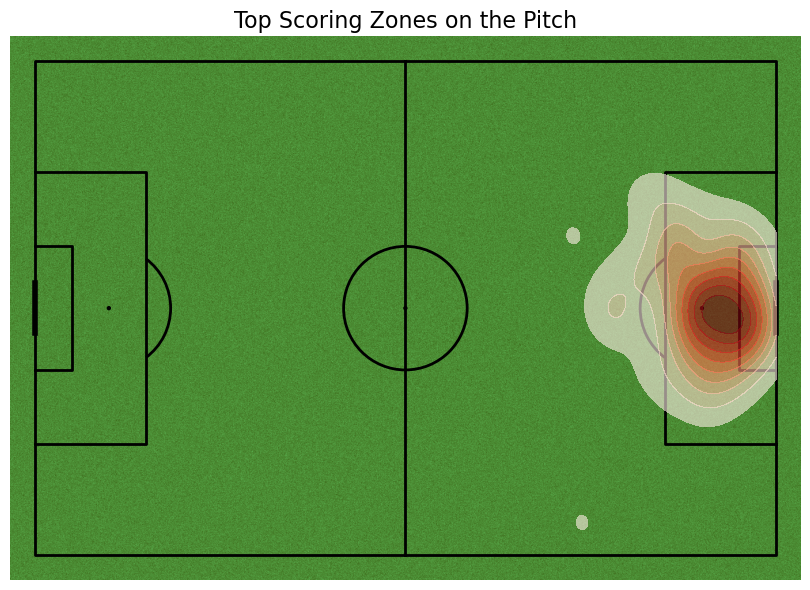

In [68]:
home_df= df[df['team'] == 'Bayer Leverkusen']


goals_df = home_df[home_df['shot_outcome'] == 'Goal']
goals_cleaned = goals_df.dropna(subset=['location']).copy()
goals_cleaned[['x', 'y']] = pd.DataFrame(goals_cleaned['location'].tolist(), index=goals_cleaned.index)

pitch = Pitch(line_color='black', pitch_type='statsbomb', pitch_color='grass')
fig, ax = pitch.draw(figsize=(10, 6))
pitch.kdeplot(goals_cleaned['x'], goals_cleaned['y'], ax=ax, fill=True, cmap='Reds', alpha=0.6)

ax.set_title("Top Scoring Zones on the Pitch", fontsize=16)
plt.show()


## 2. What is the distribution of shot outcomes?

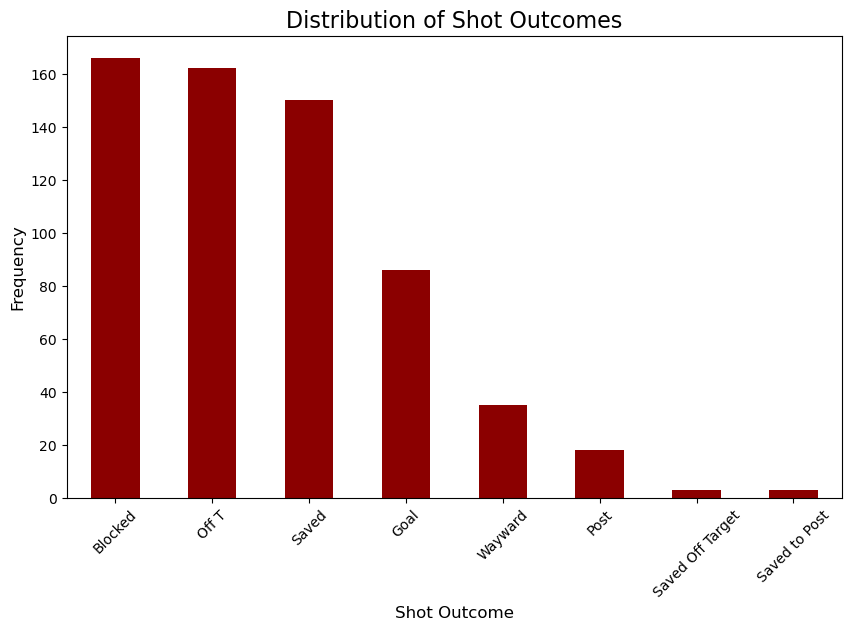

In [11]:
# Filter Shot Events
shots_df = home_df[home_df['type'] == 'Shot']

# Count the Shot Outcomes
shot_outcome_counts = shots_df['shot_outcome'].value_counts()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
shot_outcome_counts.plot(kind='bar', color='darkred')
plt.title("Distribution of Shot Outcomes", fontsize=16)
plt.xlabel("Shot Outcome", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.show()


## 3. Top players who outperformed xG

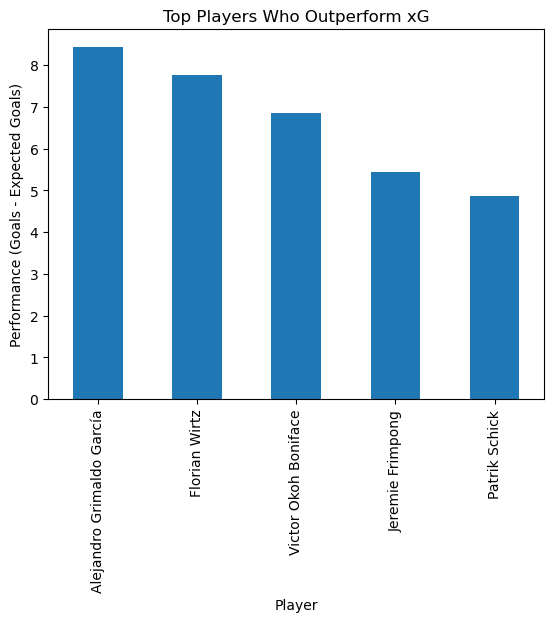

In [12]:
# Calculate goals and xG for each player
player_performance = goals_df.groupby('player')['shot_statsbomb_xg'].agg(['sum'])
player_performance['goals'] = goals_df.groupby('player')['shot_outcome'].apply(lambda x: (x == 'Goal').sum())

# Calculate performance vs expected goals
player_performance['xG_performance'] = player_performance['goals'] - player_performance['sum']

# Plot bar chart
player_performance.sort_values('xG_performance', ascending=False).head(5)['xG_performance'].plot(kind='bar')
plt.title('Top Players Who Outperform xG')
plt.xlabel('Player')
plt.ylabel('Performance (Goals - Expected Goals)')
plt.show()



## 4. Goal scoring trend vs conceded trend

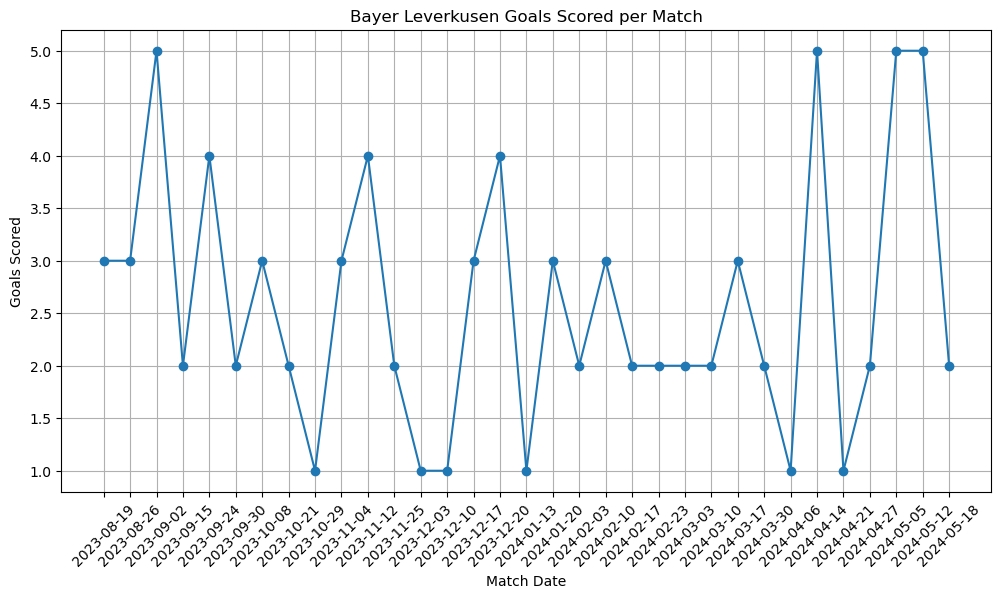

In [13]:
# Merge with match dates
goals_df = goals_df.merge(matches[['match_id', 'match_date']], on='match_id')

# Count goals per match date
goals_per_match = goals_df.groupby('match_date').size().reset_index(name='goals_scored')


plt.figure(figsize=(12, 6))
plt.plot(goals_per_match['match_date'], goals_per_match['goals_scored'], marker='o')
plt.title('Bayer Leverkusen Goals Scored per Match')
plt.xlabel('Match Date')
plt.ylabel('Goals Scored')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()





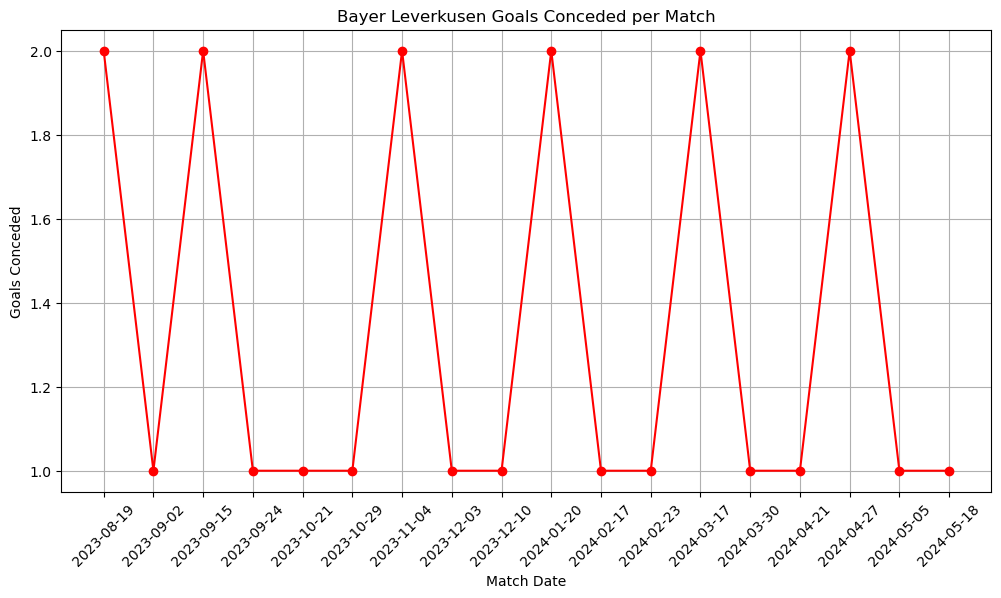

In [14]:
# Filter for goals conceded by Bayer Leverkusen
goals_conceded = home_df[(home_df['goalkeeper_type'] == 'Goal Conceded')]

# Merge with match dates
goals_conceded = goals_conceded.merge(matches[['match_id', 'match_date']], on='match_id')

# Count goals conceded per match date
goals_conceded_per_match = goals_conceded.groupby('match_date').size().reset_index(name='goals_conceded')


plt.figure(figsize=(12, 6))
plt.plot(goals_conceded_per_match['match_date'], goals_conceded_per_match['goals_conceded'], marker='o', color='red')
plt.title('Bayer Leverkusen Goals Conceded per Match')
plt.xlabel('Match Date')
plt.ylabel('Goals Conceded')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()




## 5. Bayer Leverkusen's passing network vs Bayern Munich

In [15]:
# filter for passes for a specific match against Bayern Munich
passes = home_df[(home_df['type'] == 'Pass') & (home_df['match_id'] == 3895074)]


In [16]:
passes[['x_end', 'y_end']] = pd.DataFrame(passes.pass_end_location.tolist(), index=passes.index)

C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\3845173910.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  passes[['x_end', 'y_end']] = pd.DataFrame(passes.pass_end_location.tolist(), index=passes.index)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\3845173910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes[['x_end', 'y_end']] = pd.DataFrame(passes.pass_end_location.tolist(), index=passes.index)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\3845173910.py:1: PerformanceWarning: DataFrame is hig

In [17]:
passes[['x', 'y']] = pd.DataFrame(passes.location.tolist(), index=passes.index)

C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\3469291397.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  passes[['x', 'y']] = pd.DataFrame(passes.location.tolist(), index=passes.index)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\3469291397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes[['x', 'y']] = pd.DataFrame(passes.location.tolist(), index=passes.index)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\3469291397.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

In [18]:
passes = passes[['id','player_id','player','x','y','x_end', 'y_end','pass_recipient','pass_outcome','minute']]
passes

,id,player_id,player,x,y,x_end,y_end,pass_recipient,pass_outcome,minute
55509,16252ec8-ab09-4119-bcf6-7fd6524f9128,3500.0,Granit Xhaka,60.0,40.0,42.4,44.9,Odilon Kossonou,NaN,0
55510,d6b118e9-dee4-4f3a-9046-2a086e85ca6b,27133.0,Odilon Kossonou,42.4,42.4,47.0,15.2,Edmond Fayçal Tapsoba,NaN,0
55511,d4683bb7-cdad-4a7d-9851-743212fba939,30606.0,Edmond Fayçal Tapsoba,49.1,16.6,57.1,24.8,Robert Andrich,NaN,0
55512,e8aa6b61-931b-4bf8-b329-cb66ffbd4313,9195.0,Robert Andrich,57.1,24.7,27.5,24.8,Jonathan Tah,NaN,0
55513,31528025-7c8a-4a3c-abf4-a6b496204f3f,8221.0,Jonathan Tah,25.1,25.0,10.0,40.0,Lukáš Hrádecký,NaN,0
...,...,...,...,...,...,...,...,...,...,...
56720,18660d11-fdc5-44b3-ad9f-3046bcff1844,40724.0,Florian Wirtz,97.9,50.9,109.6,51.7,Jonas Hofmann,Incomplete,91
56727,1bb7ba6c-f7ca-4104-b675-8f81cf31b32e,8221.0,Jonathan Tah,3.9,74.3,48.2,61.4,Victor Okoh Boniface,NaN,95
56730,7a21cd48-6002-4e43-8000-84b46cf472ad,8221.0,Jonathan Tah,28.2,50.4,42.2,63.3,Amine Adli,NaN,95
56731,3de3058c-7897-4d95-91f2-92e51cee3051,33401.0,Amine Adli,42.2,63.3,85.0,29.2,Adam Hložek,Incomplete,95


In [19]:
#filter for successful passes, passes which dont have a pass outcome is a successful pass
successful=passes[passes['pass_outcome'].isnull()]

In [20]:
successful

,id,player_id,player,x,y,x_end,y_end,pass_recipient,pass_outcome,minute
55509,16252ec8-ab09-4119-bcf6-7fd6524f9128,3500.0,Granit Xhaka,60.0,40.0,42.4,44.9,Odilon Kossonou,NaN,0
55510,d6b118e9-dee4-4f3a-9046-2a086e85ca6b,27133.0,Odilon Kossonou,42.4,42.4,47.0,15.2,Edmond Fayçal Tapsoba,NaN,0
55511,d4683bb7-cdad-4a7d-9851-743212fba939,30606.0,Edmond Fayçal Tapsoba,49.1,16.6,57.1,24.8,Robert Andrich,NaN,0
55512,e8aa6b61-931b-4bf8-b329-cb66ffbd4313,9195.0,Robert Andrich,57.1,24.7,27.5,24.8,Jonathan Tah,NaN,0
55513,31528025-7c8a-4a3c-abf4-a6b496204f3f,8221.0,Jonathan Tah,25.1,25.0,10.0,40.0,Lukáš Hrádecký,NaN,0
...,...,...,...,...,...,...,...,...,...,...
56716,9451d81a-6a80-405d-b65d-702ce0266f1b,40724.0,Florian Wirtz,68.0,24.6,68.3,41.8,Exequiel Alejandro Palacios,NaN,91
56717,6f7e5114-d5f4-4cd1-969b-198355f5710b,28268.0,Exequiel Alejandro Palacios,74.7,37.3,74.7,26.8,Florian Wirtz,NaN,91
56718,71351fb2-5913-4a6e-a4d5-02bf2c17ce67,40724.0,Florian Wirtz,80.8,34.4,97.1,76.3,Amine Adli,NaN,91
56727,1bb7ba6c-f7ca-4104-b675-8f81cf31b32e,8221.0,Jonathan Tah,3.9,74.3,48.2,61.4,Victor Okoh Boniface,NaN,95


In [21]:
# check for substitutions and at which minute it was made
subs = df[df['type']=='Substitution']
subs = subs['minute']
firstSub=subs.min()
firstSub

19

In [22]:
# use passses before the substitution made
successful = successful[successful['minute']<firstSub]


In [23]:
successful.columns

Index(['id', 'player_id', 'player', 'x', 'y', 'x_end', 'y_end',
       'pass_recipient', 'pass_outcome', 'minute'],
      dtype='object')

In [24]:
# get jersey numbers
df_lineup = sb.lineups(3895074)
lineup_dfs = []
for team, players in df_lineup.items():
    team_df = pd.DataFrame(players)
    team_df['team'] = team  # Add a column for the team name
    lineup_dfs.append(team_df)

df_lineup_combined = pd.concat(lineup_dfs, ignore_index=True)


In [25]:
jersey_data=df_lineup_combined[['player_name','jersey_number']]
jersey_data

,player_name,jersey_number
0,Leroy Sané,10
1,Jean-Eric Maxim Choupo-Moting,13
2,Bouna Sarr,20
3,Thomas Müller,25
4,Joshua Kimmich,6
5,Leon Goretzka,8
6,Matthijs de Ligt,4
7,Sven Ulreich,26
8,Serge Gnabry,7
9,Konrad Laimer,27


In [26]:
# add jersey numbers and names to the player who made the pass
jersey_data.rename(columns={'player_name':'player'},inplace=True)
successful= pd.merge(successful,jersey_data,on='player')
successful.rename(columns={'jersey_number':'passer'},inplace=True)
successful

C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\2094035082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jersey_data.rename(columns={'player_name':'player'},inplace=True)


,id,player_id,player,x,y,x_end,y_end,pass_recipient,pass_outcome,minute,passer
0,16252ec8-ab09-4119-bcf6-7fd6524f9128,3500.0,Granit Xhaka,60.0,40.0,42.4,44.9,Odilon Kossonou,NaN,0,34
1,d6b118e9-dee4-4f3a-9046-2a086e85ca6b,27133.0,Odilon Kossonou,42.4,42.4,47.0,15.2,Edmond Fayçal Tapsoba,NaN,0,6
2,d4683bb7-cdad-4a7d-9851-743212fba939,30606.0,Edmond Fayçal Tapsoba,49.1,16.6,57.1,24.8,Robert Andrich,NaN,0,12
3,e8aa6b61-931b-4bf8-b329-cb66ffbd4313,9195.0,Robert Andrich,57.1,24.7,27.5,24.8,Jonathan Tah,NaN,0,8
4,31528025-7c8a-4a3c-abf4-a6b496204f3f,8221.0,Jonathan Tah,25.1,25.0,10.0,40.0,Lukáš Hrádecký,NaN,0,4
...,...,...,...,...,...,...,...,...,...,...,...
59,2f15f871-dc64-4123-a455-fe4e6c742f40,8804.0,Jonas Hofmann,20.1,50.5,40.4,69.0,Jeremie Frimpong,NaN,18,7
60,38d66bc4-6a17-4bf1-93d4-a962d6874708,3500.0,Granit Xhaka,57.1,50.8,47.8,47.6,Edmond Fayçal Tapsoba,NaN,18,34
61,2c839a5e-d7f4-4ce2-90c9-afd8c6f22a4f,30606.0,Edmond Fayçal Tapsoba,51.5,42.1,44.2,48.0,Jonathan Tah,NaN,18,12
62,5dfb8365-79ad-46cb-ad5c-65723b1e0553,8221.0,Jonathan Tah,43.6,50.5,50.1,53.3,Granit Xhaka,NaN,18,4


In [27]:
# add jersey numbers and names to the player who received the pass
jersey_data.rename(columns={'player':'pass_recipient'},inplace=True)
successful = pd.merge(successful,jersey_data, on='pass_recipient')
successful.rename(columns={'jersey_number':'recipient'},inplace=True)
successful

C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\167068744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jersey_data.rename(columns={'player':'pass_recipient'},inplace=True)


,id,player_id,player,x,y,x_end,y_end,pass_recipient,pass_outcome,minute,passer,recipient
0,16252ec8-ab09-4119-bcf6-7fd6524f9128,3500.0,Granit Xhaka,60.0,40.0,42.4,44.9,Odilon Kossonou,NaN,0,34,6
1,d6b118e9-dee4-4f3a-9046-2a086e85ca6b,27133.0,Odilon Kossonou,42.4,42.4,47.0,15.2,Edmond Fayçal Tapsoba,NaN,0,6,12
2,d4683bb7-cdad-4a7d-9851-743212fba939,30606.0,Edmond Fayçal Tapsoba,49.1,16.6,57.1,24.8,Robert Andrich,NaN,0,12,8
3,e8aa6b61-931b-4bf8-b329-cb66ffbd4313,9195.0,Robert Andrich,57.1,24.7,27.5,24.8,Jonathan Tah,NaN,0,8,4
4,31528025-7c8a-4a3c-abf4-a6b496204f3f,8221.0,Jonathan Tah,25.1,25.0,10.0,40.0,Lukáš Hrádecký,NaN,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
59,2f15f871-dc64-4123-a455-fe4e6c742f40,8804.0,Jonas Hofmann,20.1,50.5,40.4,69.0,Jeremie Frimpong,NaN,18,7,30
60,38d66bc4-6a17-4bf1-93d4-a962d6874708,3500.0,Granit Xhaka,57.1,50.8,47.8,47.6,Edmond Fayçal Tapsoba,NaN,18,34,12
61,2c839a5e-d7f4-4ce2-90c9-afd8c6f22a4f,30606.0,Edmond Fayçal Tapsoba,51.5,42.1,44.2,48.0,Jonathan Tah,NaN,18,12,4
62,5dfb8365-79ad-46cb-ad5c-65723b1e0553,8221.0,Jonathan Tah,43.6,50.5,50.1,53.3,Granit Xhaka,NaN,18,4,34


In [28]:
# calculate average locations of the passer by grouping by the passer
average_locations= successful.groupby('passer').agg({'x':['mean'],'y':['mean','count']})
average_locations.columns = ['x','y','count']
average_locations

,x,y,count
passer,,,
1,11.000000,40.275000,4
4,37.128571,42.542857,7
6,33.075000,64.175000,8
7,33.733333,62.666667,6
8,48.550000,48.575000,8
10,52.100000,39.300000,4
12,42.575000,29.675000,8
20,59.066667,4.700000,3
30,54.760000,79.180000,5


In [29]:
# calculate average locations of the recipient by grouping by the recipient
pass_between = successful.groupby(['passer','recipient']).id.count().reset_index()
pass_between.rename({'id':'pass_count'},axis='columns',inplace=True)
pass_between

,passer,recipient,pass_count
0,1,6,1
1,1,22,1
2,1,34,2
3,4,1,1
4,4,6,1
5,4,7,1
6,4,8,1
7,4,12,1
8,4,34,2
9,6,7,1


In [30]:
#merge
pass_between= pd.merge(pass_between, average_locations, on='passer')
pass_between

,passer,recipient,pass_count,x,y,count
0,1,6,1,11.000000,40.275000,4
1,1,22,1,11.000000,40.275000,4
2,1,34,2,11.000000,40.275000,4
3,4,1,1,37.128571,42.542857,7
4,4,6,1,37.128571,42.542857,7
5,4,7,1,37.128571,42.542857,7
6,4,8,1,37.128571,42.542857,7
7,4,12,1,37.128571,42.542857,7
8,4,34,2,37.128571,42.542857,7
9,6,7,1,33.075000,64.175000,8


In [31]:
average_locations=average_locations.rename_axis('recipient')
pass_between= pd.merge(pass_between, average_locations, on='recipient',suffixes=['','_end'])
pass_between

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
0,1,6,1,11.000000,40.275000,4,33.075000,64.175000,8
1,1,34,2,11.000000,40.275000,4,49.372727,38.790909,11
2,4,1,1,37.128571,42.542857,7,11.000000,40.275000,4
3,4,6,1,37.128571,42.542857,7,33.075000,64.175000,8
4,4,7,1,37.128571,42.542857,7,33.733333,62.666667,6
5,4,8,1,37.128571,42.542857,7,48.550000,48.575000,8
6,4,12,1,37.128571,42.542857,7,42.575000,29.675000,8
7,4,34,2,37.128571,42.542857,7,49.372727,38.790909,11
8,6,7,1,33.075000,64.175000,8,33.733333,62.666667,6
9,6,8,2,33.075000,64.175000,8,48.550000,48.575000,8


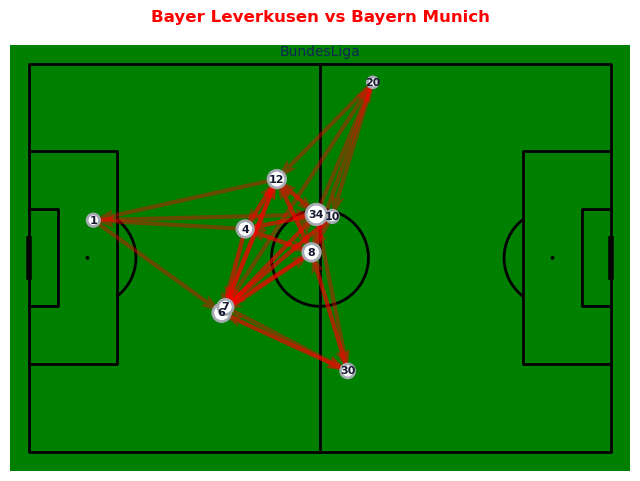

In [32]:
pitch = Pitch(pitch_color='green', line_color='black')
fig, ax = pitch.draw(figsize=(8, 6), constrained_layout=True, tight_layout=False)

fig.set_facecolor('white')

# Draw arrows and nodes
arrows = pitch.arrows(1.2 * pass_between.x, 0.8 * pass_between.y, 1.2 * pass_between.x_end, 0.8 * pass_between.y_end, ax=ax,color='red', alpha=0.4,width=3)
# arrows = pass_between.apply(create_arrow, axis=1)
# for arrow in arrows:
#     ax.add_patch(arrow)
                 
nodes = pitch.scatter(1.2 * average_locations.x, 0.8 * average_locations.y, s=20*average_locations['count'].values, color='white', edgecolors='#a6aab3', linewidth=2, alpha=1, zorder=1, ax=ax)

                 
# Annotate average_locations
for index, row in average_locations.iterrows():
    pitch.annotate(index, xy=(1.2 * row.x, 0.8 * row.y), c='#161A30',fontweight='bold', va='center', ha='center', size=8, ax=ax)



ax.set_title('Bayer Leverkusen vs Bayern Munich', color='red', va='center', ha='center', fontsize=12,fontweight='bold',pad=20,loc='center')
ax.annotate('BundesLiga', xy=(0.5, 1), xytext=(0, 0),
             xycoords='axes fraction', textcoords='offset points',
             fontsize=10, color='#0E2954', va='top', ha='center')


plt.show()

## 6. Does the shot distance show a liklihood to scoring?

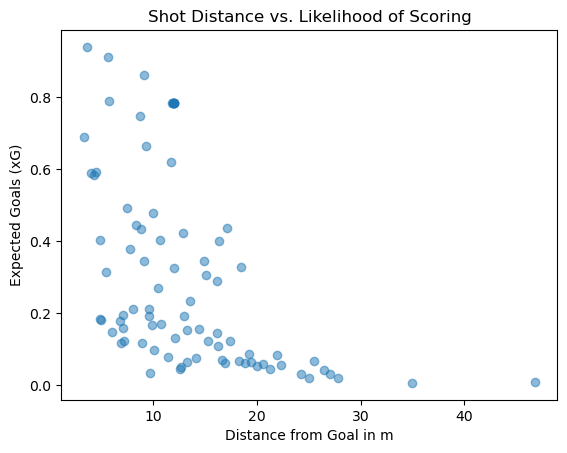

In [33]:
# Calculate distance from goal
goals_cleaned['distance_from_goal'] = ((goals_cleaned['x'] - 120)**2 + (goals_cleaned['y'] - 40)**2) ** 0.5

# Scatter plot
plt.scatter(goals_cleaned['distance_from_goal'], goals_cleaned['shot_statsbomb_xg'], alpha=0.5)
plt.title('Shot Distance vs. Likelihood of Scoring')
plt.xlabel('Distance from Goal in m')
plt.ylabel('Expected Goals (xG)')
plt.show()


## 7. Where has Wirtz been deployed on the pitch?

In [34]:
# Filter the DataFrame for the specific match_id
touches_team = home_df[home_df['match_id'] == 3895074]

# Drop rows where 'location' is NaN
touches_team = touches_team.dropna(subset=['location'])

# Split the 'location' column into 'x' and 'y' coordinates
touches_team[['x', 'y']] = pd.DataFrame(touches_team['location'].tolist(), index=touches_team.index)



C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\37514012.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  touches_team[['x', 'y']] = pd.DataFrame(touches_team['location'].tolist(), index=touches_team.index)
C:\Users\harsh\AppData\Local\Temp\ipykernel_10680\37514012.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  touches_team[['x', 'y']] = pd.DataFrame(touches_team['location'].tolist(), index=touches_team.index)


,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,...,dribble_no_touch,goalkeeper_shot_saved_off_target,shot_saved_off_target,goalkeeper_shot_saved_to_post,shot_saved_to_post,clearance_other,goalkeeper_success_out,goalkeeper_success_in_play,x,y
55509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,40.0
55510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.4,42.4
55511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.1,16.6
55512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.1,24.7
55513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.1,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.9,25.0
59817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,56.1
59819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.8,49.4
59821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,26.3


In [35]:
touches_team = touches_team[['id','player','x','y']]
player_name ='Florian Wirtz'
touches_player= touches_team[touches_team['player']==player_name]



,id,player,x,y
55584,5f4d249d-781d-4e55-93cd-45a93e706aa6,Florian Wirtz,41.1,24.0
55589,607c5b51-d7ec-438d-93ef-ebf85683ee29,Florian Wirtz,60.0,40.0
55666,5b766ab0-c0e7-421d-9017-6e134acdefc1,Florian Wirtz,29.9,22.9
55674,84d53161-5d09-408b-b02a-b3312523aaee,Florian Wirtz,77.4,70.3
55691,bcbc2664-cf02-4cc2-bad3-ad63818e5800,Florian Wirtz,71.6,62.9
...,...,...,...,...
59742,1b7ba203-085b-4bb4-bfd1-a6f63b96c052,Florian Wirtz,78.4,69.2
59750,3c7ad78b-1cbe-420a-a690-85a0bc3a4549,Florian Wirtz,54.0,10.9
59753,8ab504f3-e244-46f8-b567-75353cf2f30a,Florian Wirtz,66.4,59.3
59787,ad8f0f61-593c-4bef-9460-3910d48691a7,Florian Wirtz,42.8,3.4


Text(0.107, 0.05, ' Total Touches: 273  ')

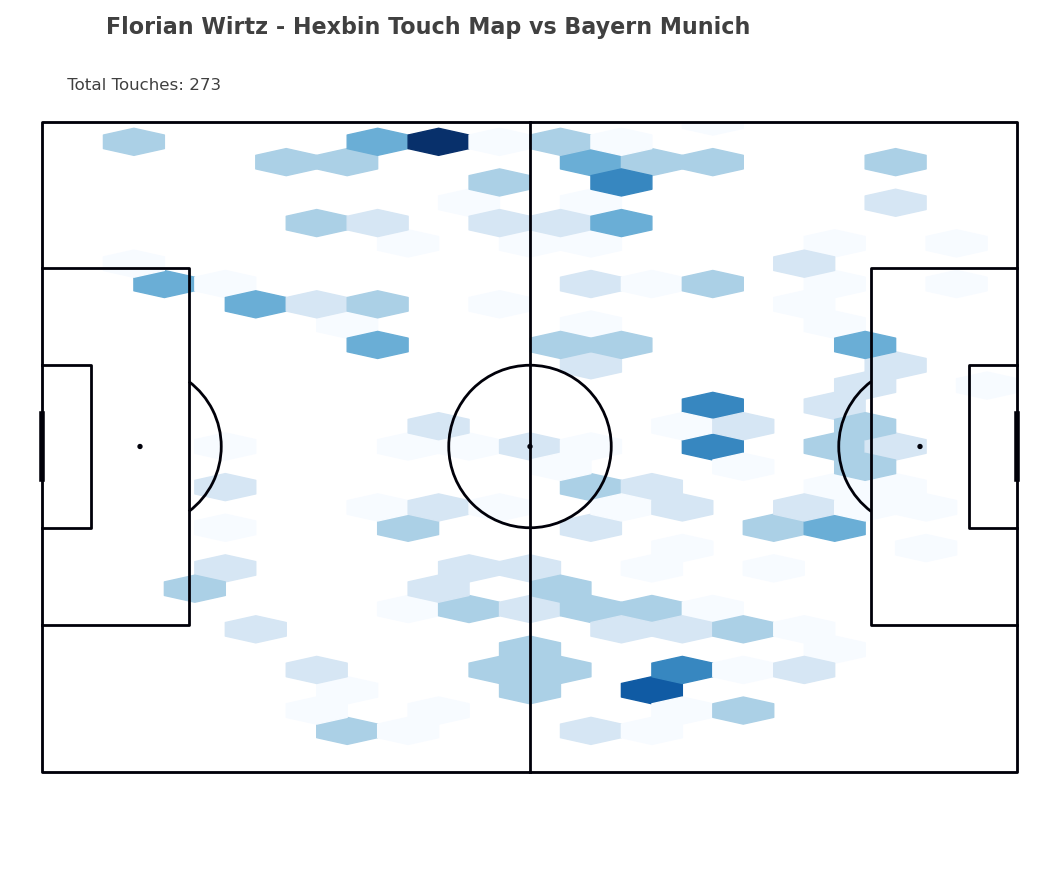

In [36]:
pitch = Pitch(line_color='#000009', line_zorder=2, )
fig, axs = pitch.grid(figheight=10, title_height=0.08, endnote_space=0,
                      title_space=0,
                      axis=False,)
hexmap = pitch.hexbin(touches_player.x, touches_player.y, ax=axs['pitch'], 
                      gridsize=(16, 16), cmap="Blues")


axs['title'].text(0.4, 0.7, f'{player_name} - Hexbin Touch Map vs Bayern Munich ', weight = 'bold', alpha = .75,
                 ha='center', fontsize=16)



axs['title'].text(0.107, 0.05, f' Total Touches: {len(touches_player)}  ', alpha = .75,
                  va='center', ha='center', fontsize=12)



## 8. How have Leverkusen performed at home and away games?

In [37]:
# Create a new column to indicate home or away games for Bayer Leverkusen
matches['location'] = matches.apply(lambda x: 'Home' if x['home_team'] == 'Bayer Leverkusen' else 'Away', axis=1)

In [38]:
matches['result'] = matches.apply(
    lambda x: 'Win' if (
        (x['home_team'] == 'Bayer Leverkusen' and x['home_score'] > x['away_score']) or
        (x['away_team'] == 'Bayer Leverkusen' and x['away_score'] > x['home_score'])
    ) else (
        'Loss' if (
            (x['home_team'] == 'Bayer Leverkusen' and x['home_score'] < x['away_score']) or
            (x['away_team'] == 'Bayer Leverkusen' and x['away_score'] < x['home_score'])
        ) else 'Draw'
    ),
    axis=1
)


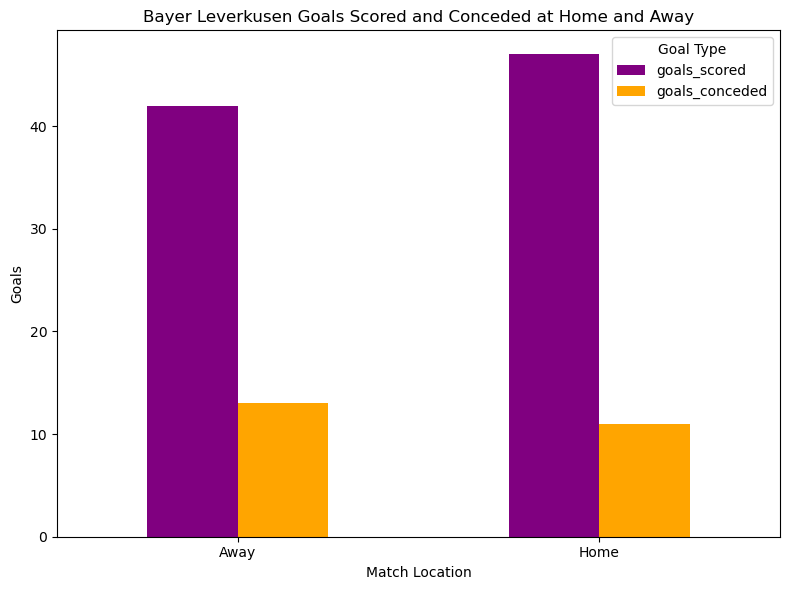

In [39]:
matches['goals_scored'] = matches.apply(
    lambda row: row['home_score'] if row['location'] == 'Home' else row['away_score'], axis=1
)
matches['goals_conceded'] = matches.apply(
    lambda row: row['away_score'] if row['location'] == 'Home' else row['home_score'], axis=1
)
location_goals = matches.groupby('location')[['goals_scored', 'goals_conceded']].sum()
import matplotlib.pyplot as plt

# Plotting
location_goals.plot(kind='bar', figsize=(8, 6), color=['purple', 'orange'])
plt.title('Bayer Leverkusen Goals Scored and Conceded at Home and Away')
plt.ylabel('Goals')
plt.xlabel('Match Location')
plt.xticks(rotation=0)
plt.legend(title='Goal Type')
plt.tight_layout()
plt.show()


In [40]:
result_counts = matches.groupby(['location', 'result']).size().unstack(fill_value=0)
result_counts

result,Draw,Win
location,,
Away,3,14
Home,3,14


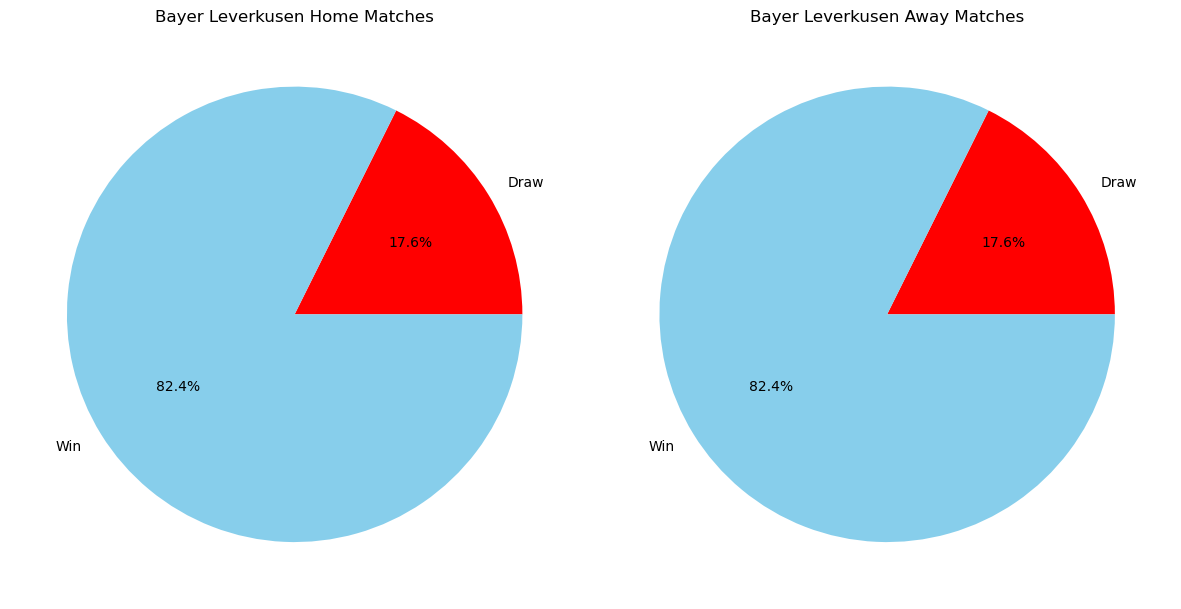

In [41]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Home matches
axes[0].pie(result_counts.loc['Home'], labels=result_counts.columns, autopct='%1.1f%%', colors=['red','skyblue','green'])
axes[0].set_title('Bayer Leverkusen Home Matches')

# Away matches
axes[1].pie(result_counts.loc['Away'], labels=result_counts.columns, autopct='%1.1f%%', colors=['red','skyblue','green'])
axes[1].set_title('Bayer Leverkusen Away Matches')

plt.tight_layout()
plt.show()


## 9. Cross and Passes that led to goals

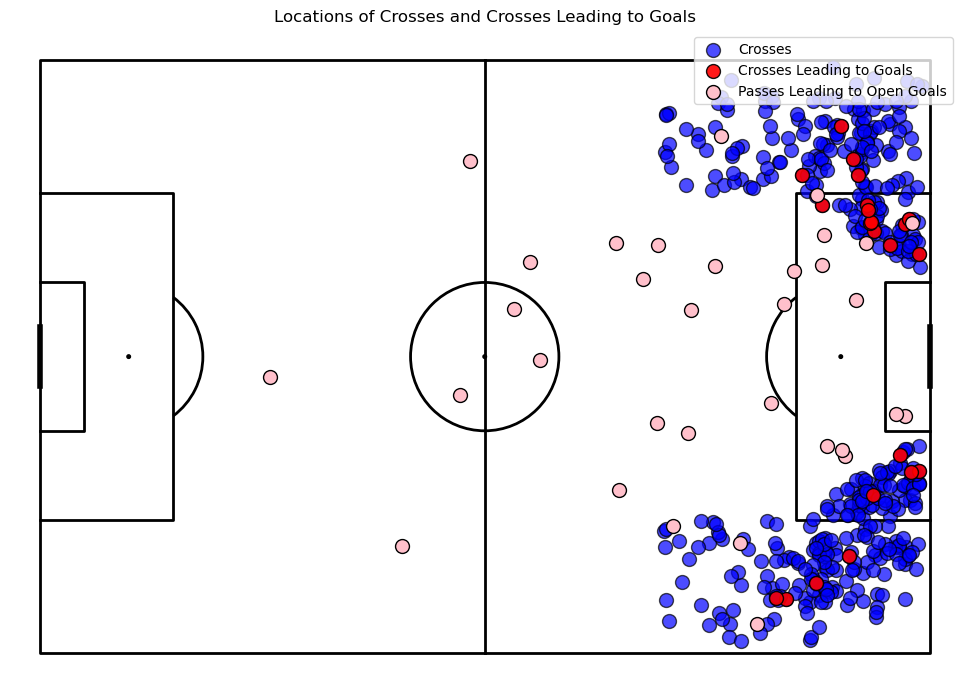

In [124]:
# Filter for crosses
cross_df = home_df[home_df['pass_cross'] == 1].dropna(subset=['location']).copy()
cross_df[['cx', 'cy']] = pd.DataFrame(cross_df['location'].tolist(), index=cross_df.index)

# Filter for crosses that resulted in goals
cross_goal = home_df[(home_df['pass_cross'] == 1) & (home_df['pass_goal_assist'] == 1)].dropna(subset=['location']).copy()
cross_goal[['cxg', 'cyg']] = pd.DataFrame(cross_goal['location'].tolist(), index=cross_goal.index)

# Filter for crosses that resulted in goals
pass_goal = home_df[(home_df['pass_cross'] != 1) & (home_df['pass_goal_assist'] == 1) & (home_df['pass_type'].isna())].dropna(subset=['location']).copy()
pass_goal[['xxx', 'yyy']] = pd.DataFrame(pass_goal['location'].tolist(), index=pass_goal.index)


pitch = Pitch(pitch_type='statsbomb', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

# Plot all crosses
pitch.scatter(cross_df['cx'], cross_df['cy'], ax=ax, color='blue', label='Crosses', s=100, edgecolors='black', alpha=0.7)

# Plot crosses leading to goals on top
pitch.scatter(cross_goal['cxg'], cross_goal['cyg'], ax=ax, color='pink', label='Crosses Leading to Goals', s=100, edgecolors='black', alpha=0.9)
pitch.scatter(pass_goal['xxx'], pass_goal['yyy'], ax=ax, color='red', label='Passes Leading to Open Goals', s=100, edgecolors='black', alpha=1.0)

plt.legend(loc='upper right')


plt.title('Locations of Crosses and Crosses Leading to Goals')


plt.show()


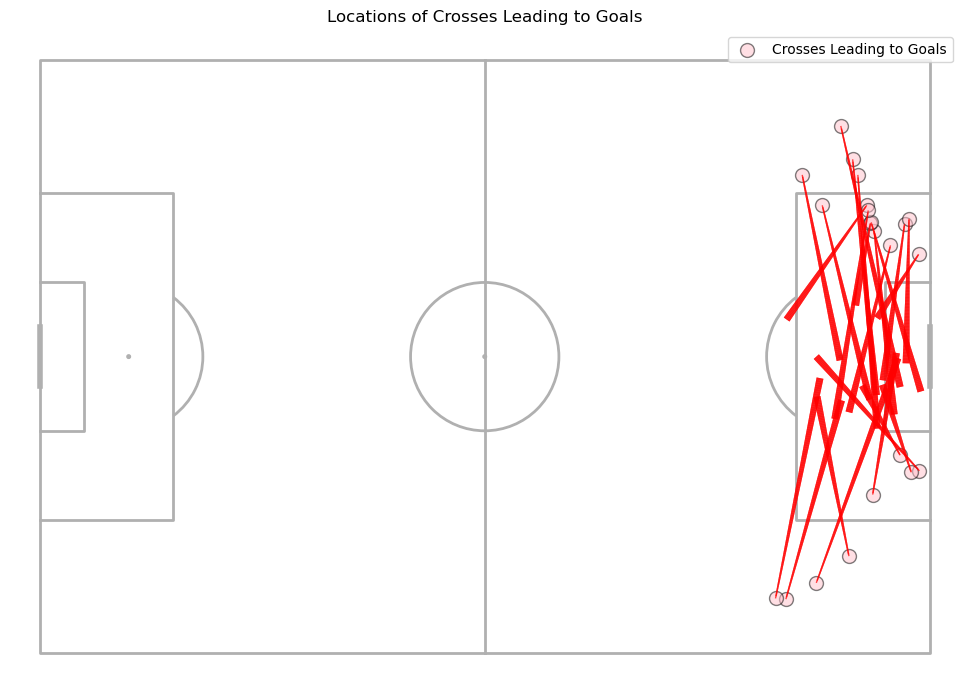

In [151]:
# Filter for crosses that resulted in goals
cross_goal = home_df[(home_df['pass_cross'] == 1) & (home_df['pass_goal_assist'] == 1)].dropna(subset=['location']).copy()
cross_goal[['cxg', 'cyg']] = pd.DataFrame(cross_goal['location'].tolist(), index=cross_goal.index)
cross_goal[['cxg_end', 'cyg_end']] = pd.DataFrame(cross_goal['pass_end_location'].dropna().tolist(), index=cross_goal.dropna(subset=['pass_end_location']).index)



# Create a pitch
pitch = Pitch(pitch_type='statsbomb')
fig, ax = pitch.draw(figsize=(10, 7))



# Plot crosses leading to goals on top
pitch.scatter(cross_goal['cxg'], cross_goal['cyg'], ax=ax, color='pink', label='Crosses Leading to Goals', s=100, edgecolors='black', alpha=0.5)
pitch.lines(xstart=cross_goal['cxg'], ystart=cross_goal['cyg'], xend=cross_goal['cxg_end'], yend=cross_goal['cyg_end'],ax=ax, color='red', alpha=0.7,comet=True)

plt.legend(loc='upper right')


plt.title('Locations of Crosses Leading to Goals')


plt.show()


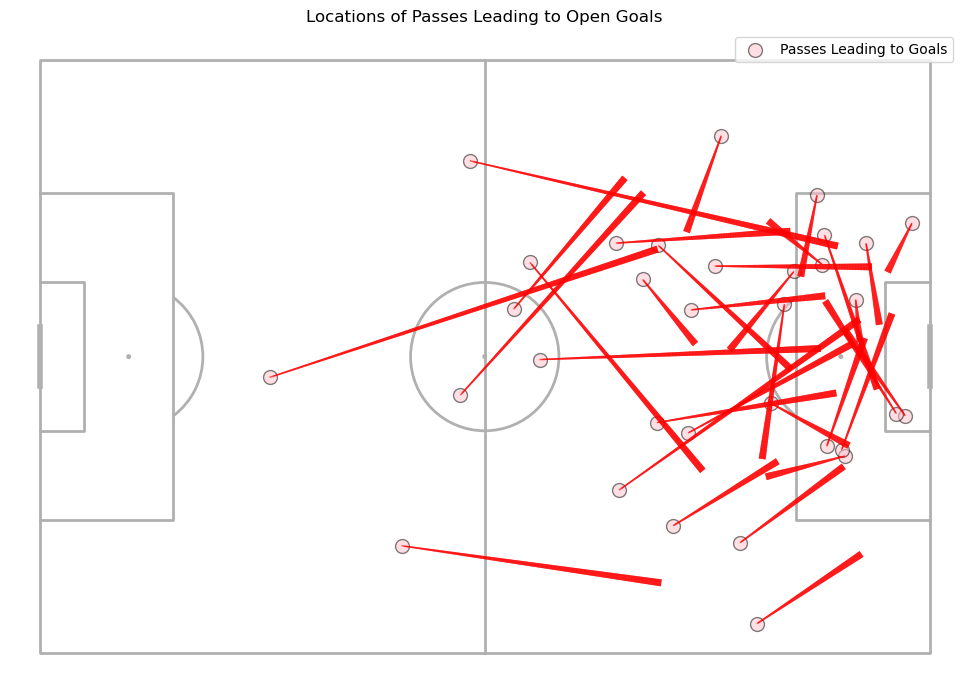

In [158]:
# Filter for passes that resulted in goals
pass_goal = home_df[(home_df['pass_cross'] != 1) & (home_df['pass_goal_assist'] == 1) & (home_df['pass_type'].isna())].dropna(subset=['location']).copy()
pass_goal[['xxx', 'yyy']] = pd.DataFrame(pass_goal['location'].tolist(), index=pass_goal.index)
pass_goal[['xxx_end', 'yyy_end']] = pd.DataFrame(pass_goal['pass_end_location'].dropna().tolist(), index=pass_goal.dropna(subset=['pass_end_location']).index)
                                               
# Create a pitch
pitch = Pitch(pitch_type='statsbomb')
fig, ax = pitch.draw(figsize=(10, 7))



# Plot crosses leading to goals on top
pitch.scatter(pass_goal['xxx'], pass_goal['yyy'], ax=ax, color='pink', label='Passes Leading to Goals', s=100, edgecolors='black', alpha=0.5)
pitch.lines(xstart=pass_goal['xxx'], ystart=pass_goal['yyy'], xend=pass_goal['xxx_end'], yend=pass_goal['yyy_end'],ax=ax, color='red', alpha=0.7,comet=True)

plt.legend(loc='upper right')


plt.title('Locations of Passes Leading to Open Goals')


plt.show()


## 10. Which player created most chances?

The player with the most chances created is Alejandro Grimaldo García with 76 chances.


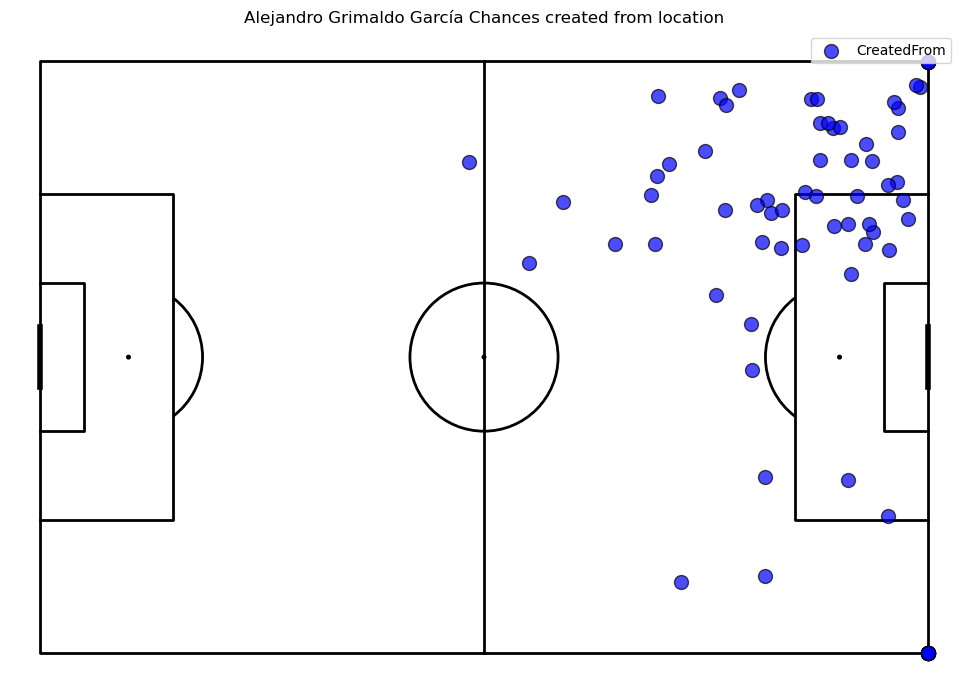

In [159]:
# Filter passes leading to shots or goals
chances_df = home_df[(home_df['pass_goal_assist'] == 1) | (home_df['pass_shot_assist'] == 1)]

# Group by player and count the number of chances created
chances_count = chances_df.groupby('player').size()

# Identify the player with the most chances created
top_player = chances_count.idxmax()
top_chances = chances_count.max()

print(f"The player with the most chances created is {top_player} with {top_chances} chances.")
chances_df=chances_df[chances_df['player']==top_player]
chances_df=chances_df.dropna(subset=['location']).copy()
chances_df[['xx', 'yy']] = pd.DataFrame(chances_df['location'].tolist(), index=chances_df.index)

# Create a pitch
pitch = Pitch(pitch_type='statsbomb', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

# Plot all crosses
pitch.scatter(chances_df['xx'], chances_df['yy'], ax=ax, color='blue', label='CreatedFrom', s=100, edgecolors='black', alpha=0.7)



plt.legend(loc='upper right')


plt.title(f'{top_player} Chances created from location')


plt.show()
